# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import plotly
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Предоставлены данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Данные о клиентах банка:**
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**
- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**
- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании - до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).
- И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [6]:
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))
# Вычислите среднее значение по преобразованному в корректный вид признаку balance.
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
# Вычислите среднее значение по преобразованному в корректный вид признаку balance.
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [9]:
#df['job'].value_counts()

In [10]:
#df['education'].value_counts()

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

In [12]:
df_moda = df[(df.job == df['job'].mode()[0]) & (df.education == df['education'].mode()[0])]
round(df_moda['balance'].mean(), 3)

1598.883

### Задание 6

In [13]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
quantile_1, quantile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75) # вычислить 25-ый и 75-ый квантили (первый и третий квартили)
iqr = quantile_3 - quantile_1 # вычислить межквартильное расстояние
# вычислить верхнюю и нижнюю границы Тьюки
lower_bound = quantile_1 - iqr * 1.5
upper_bound = quantile_3 + iqr * 1.5
outliers = df[(df['balance'] <= lower_bound) | (df['balance'] >= upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)].reset_index().drop('index', axis=1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df .shape[0]}')
print(f'Верхняя граница: {upper_bound}')
print(f'Нижняя граница: {lower_bound}')

Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105
Верхняя граница: 4063.0
Нижняя граница: -2241.0


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

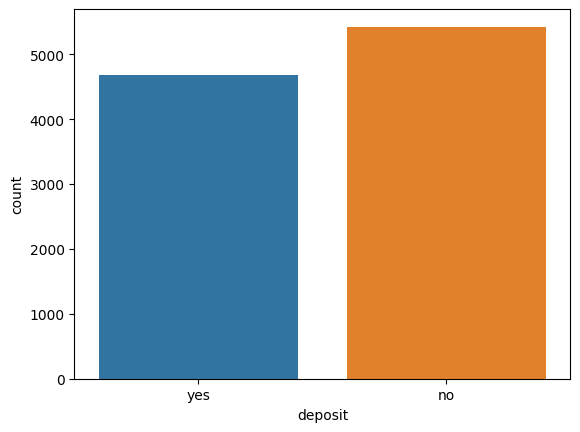

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit')
display(df['deposit'].value_counts())

Классы относительно сбалансированы.

### Задания 2 и 3

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [16]:
# Для удобства переобозначим целевой признак
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

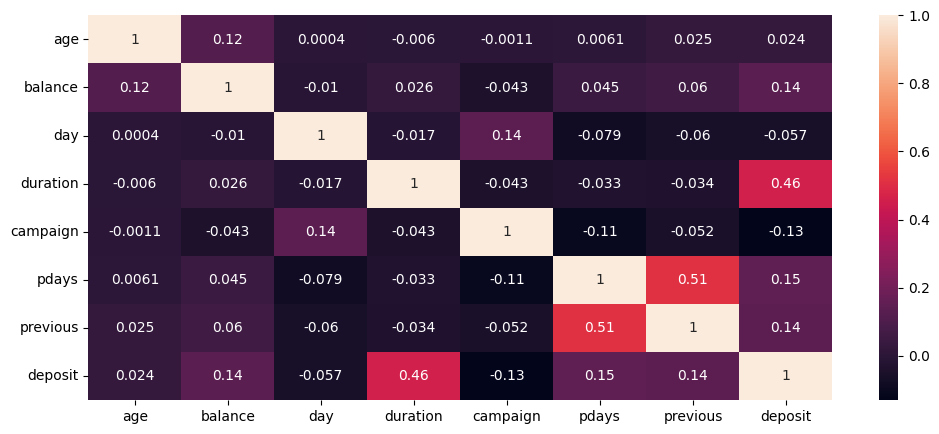

In [17]:
# карта корреляций между числовыми признаками
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(), annot=True);

Cильной корреляции между числовыми признаками нет

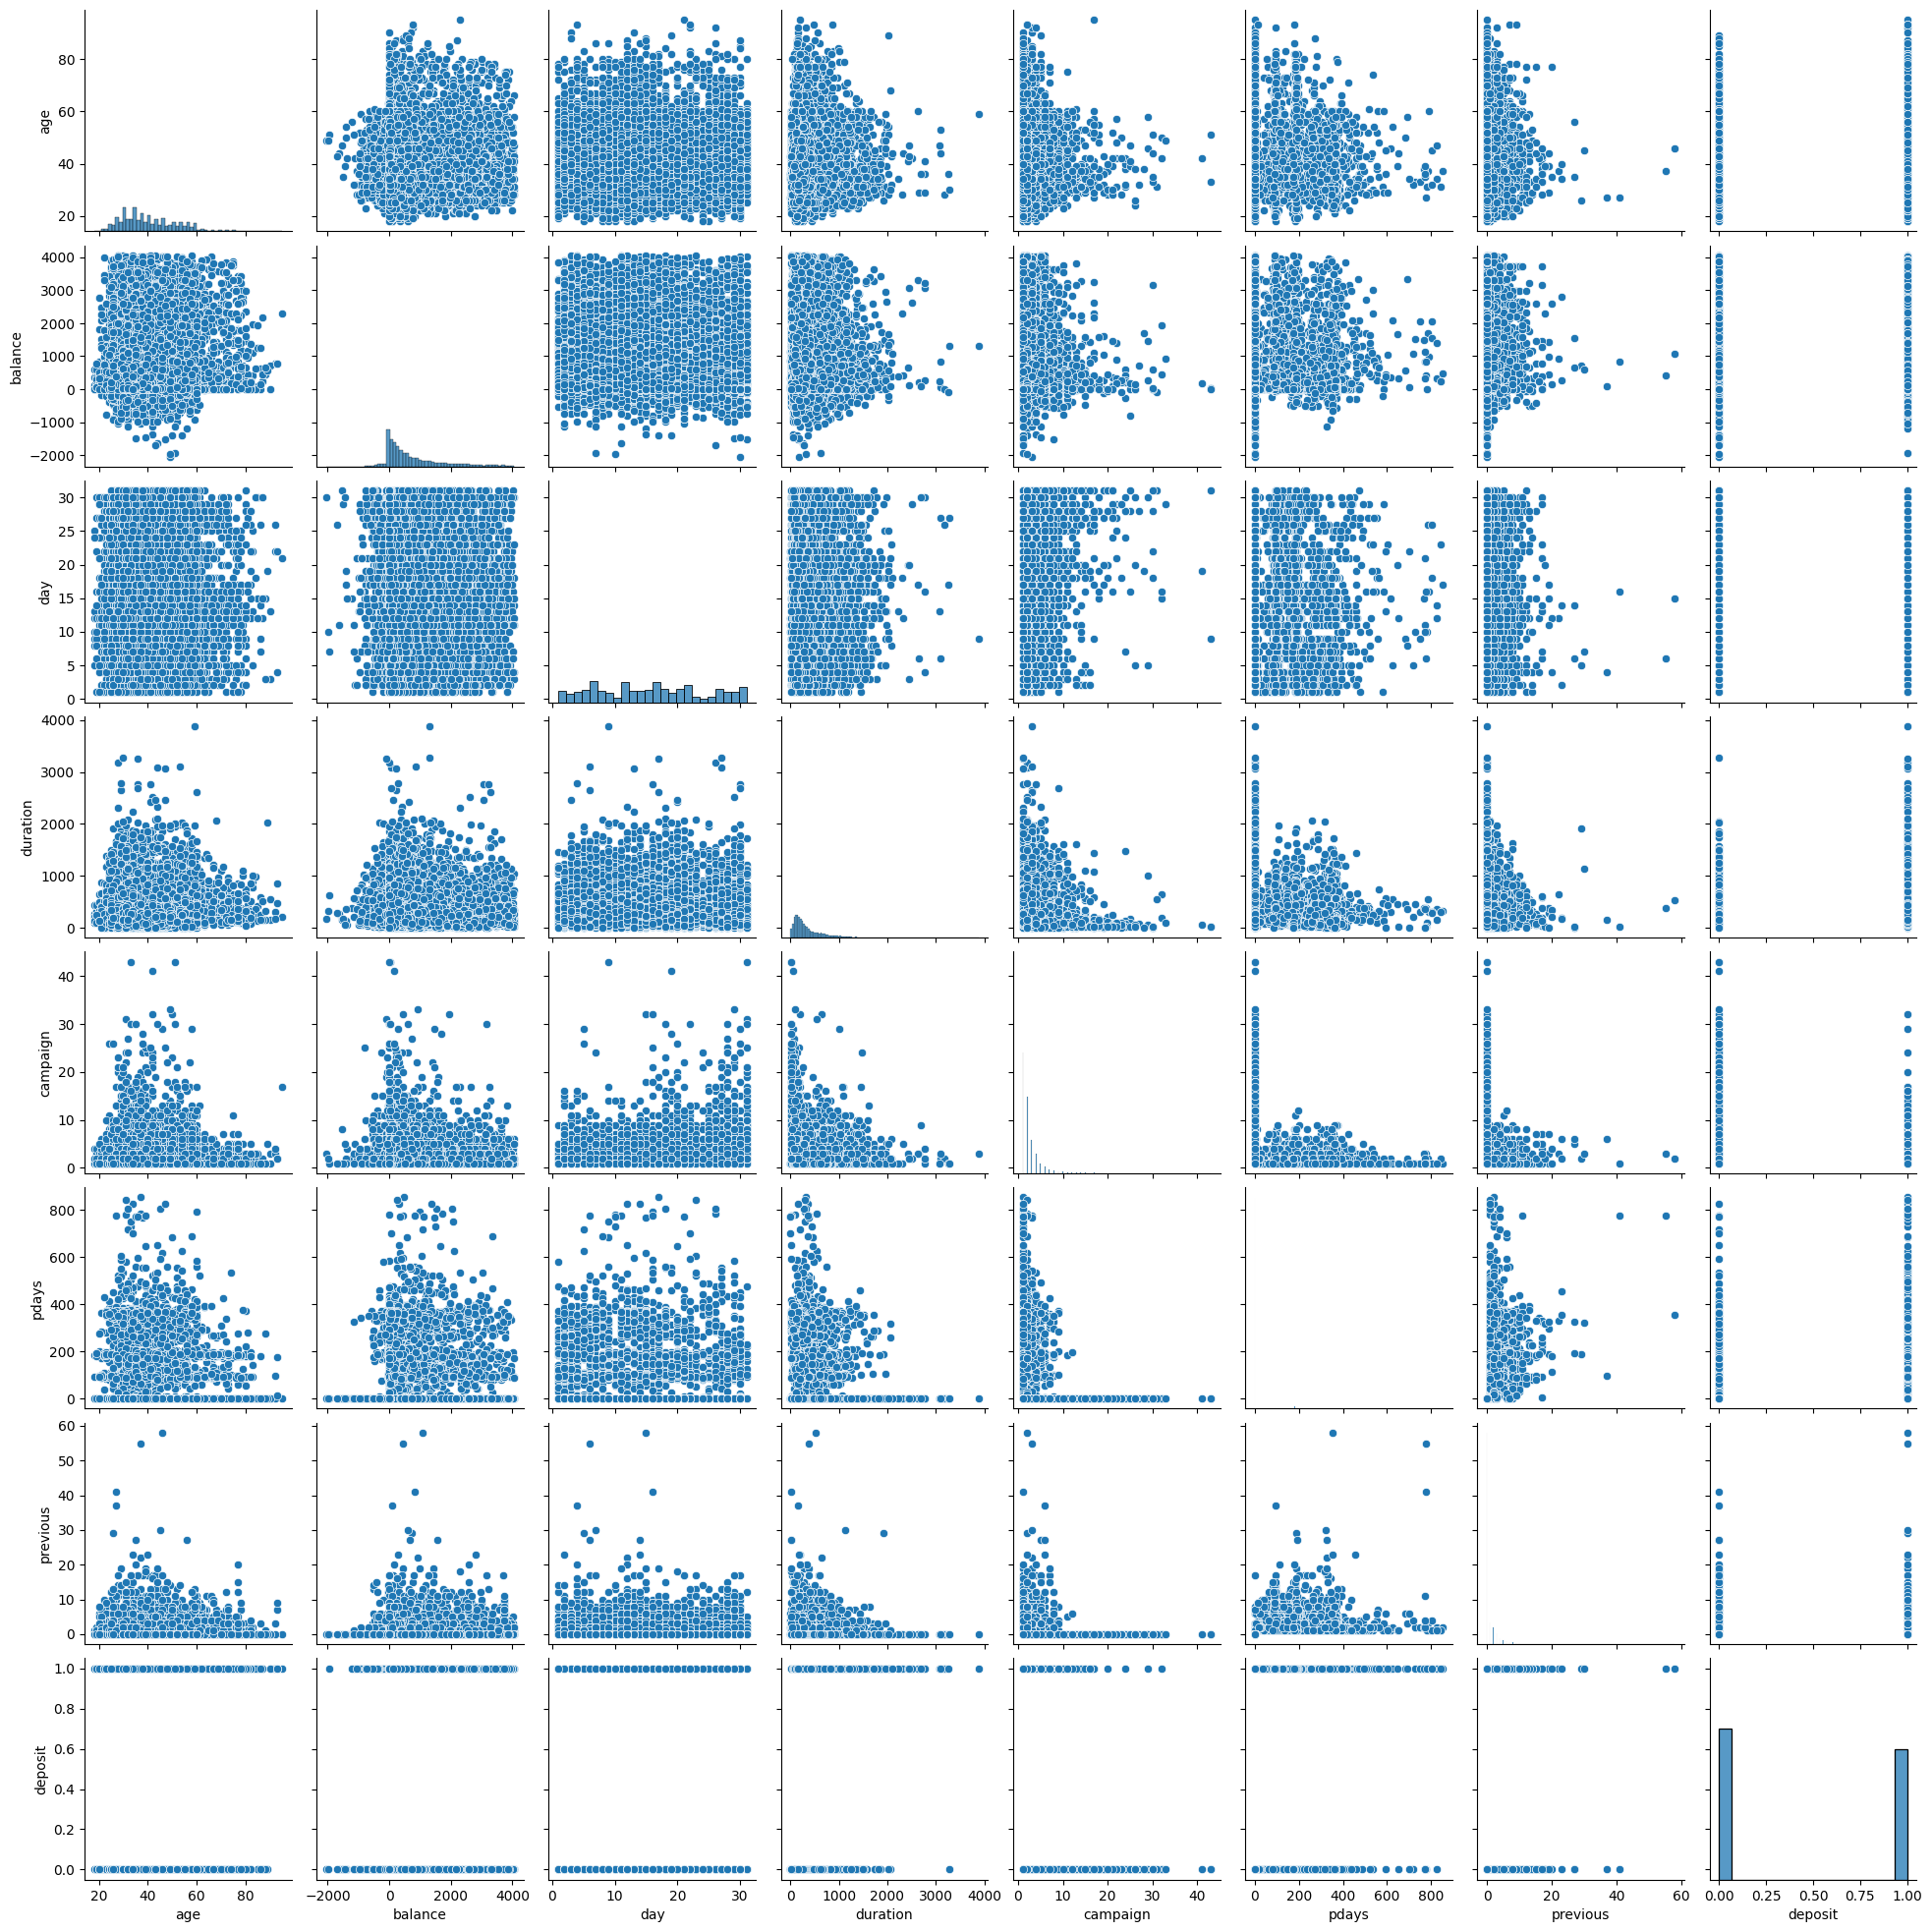

In [18]:
# посмотрим попарную зависимость между всеми числовыми признаками
sns.pairplot(df)

### Задания 4 и 5

In [19]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


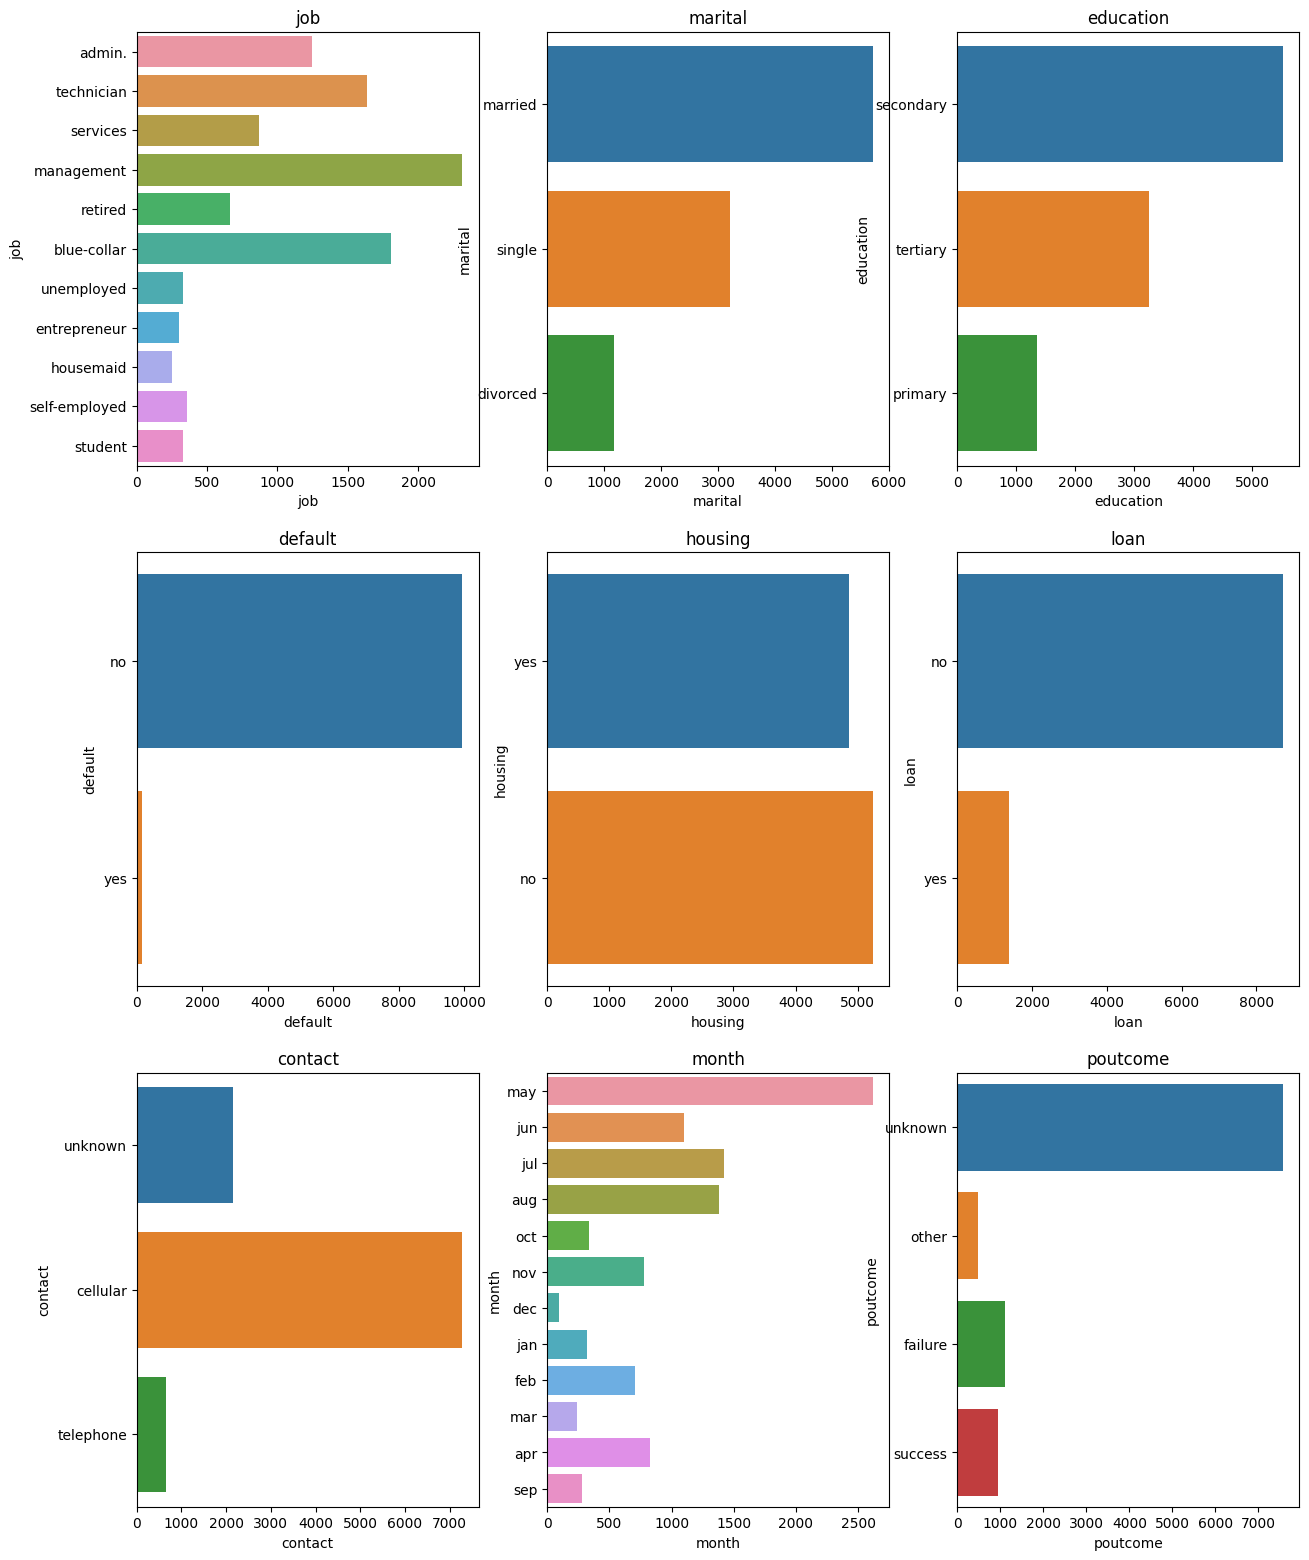

In [20]:
#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
categorical_features=[feature for feature in df.columns if (df[feature].dtypes=='O')]

import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

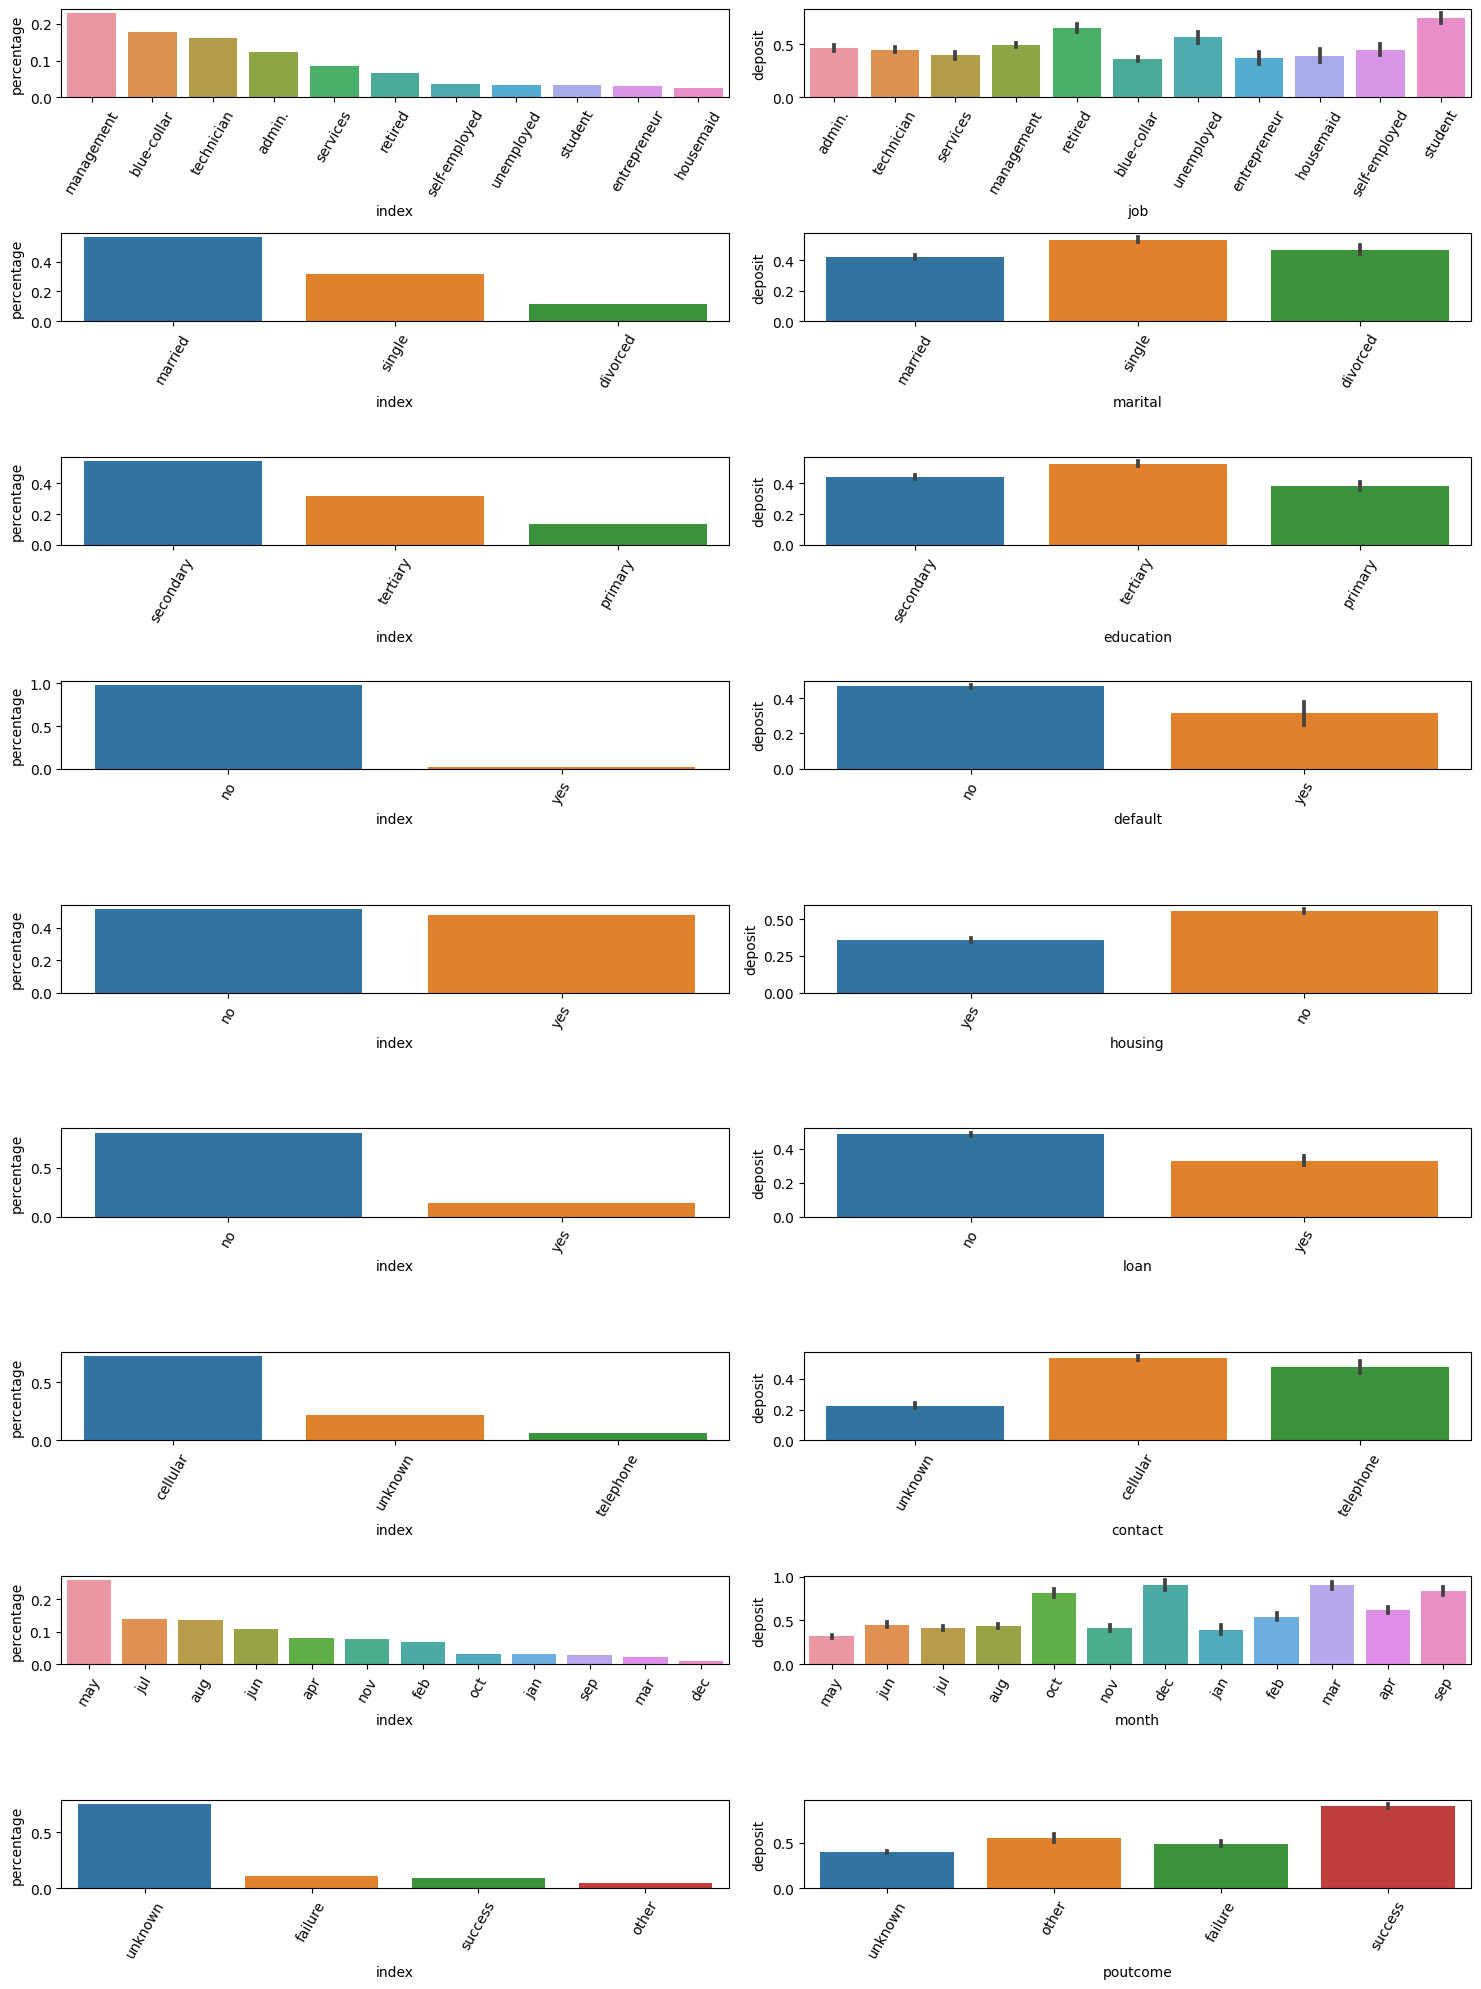

In [21]:
#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей, взявших депозит, в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

In [22]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts(normalize=True)*100

poutcome  deposit
failure   0          50.676285
          1          49.323715
other     1          55.093555
          0          44.906445
success   1          91.111111
          0           8.888889
unknown   0          60.264201
          1          39.735799
Name: deposit, dtype: float64

Для клиентов группы poutcome(succes) в предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 7

In [23]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# доля не открытых депозитов в общем количестве
percent_failure = round((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(percent_failure)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

month
may    68.0
jan    61.0
jul    59.0
nov    58.0
aug    56.0
jun    55.0
feb    46.0
apr    38.0
oct    19.0
sep    17.0
dec    10.0
mar    10.0
Name: deposit, dtype: float64
В may месяце больше всего отказывались от открытия депозита.


### Задание 8

In [24]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

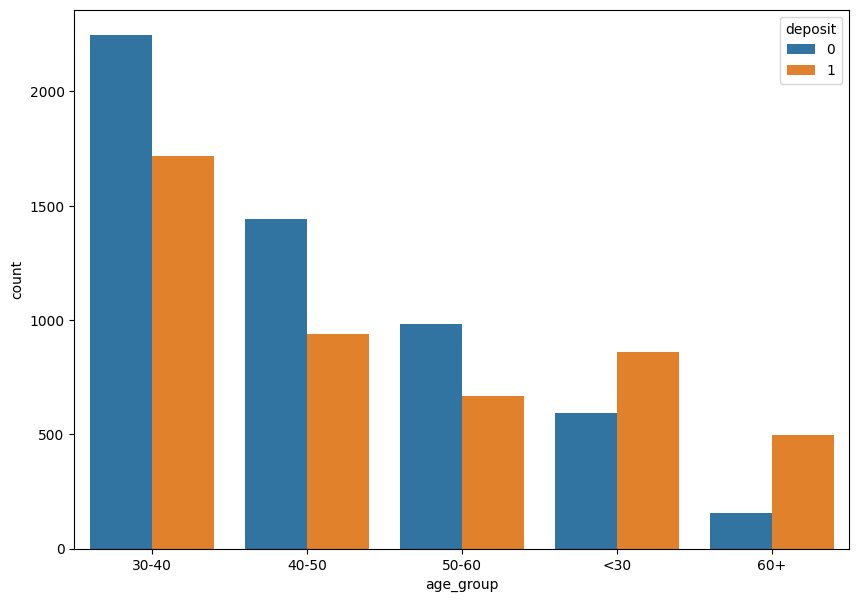

In [25]:
# построение диаграммы
fig = plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='age_group', hue='deposit', order=df['age_group'].value_counts().index);

В возрастных группах младше 30 и старше 60 лет более склонны открывать депозит, чем отказываться от предложения.

### Задания 9 и 10

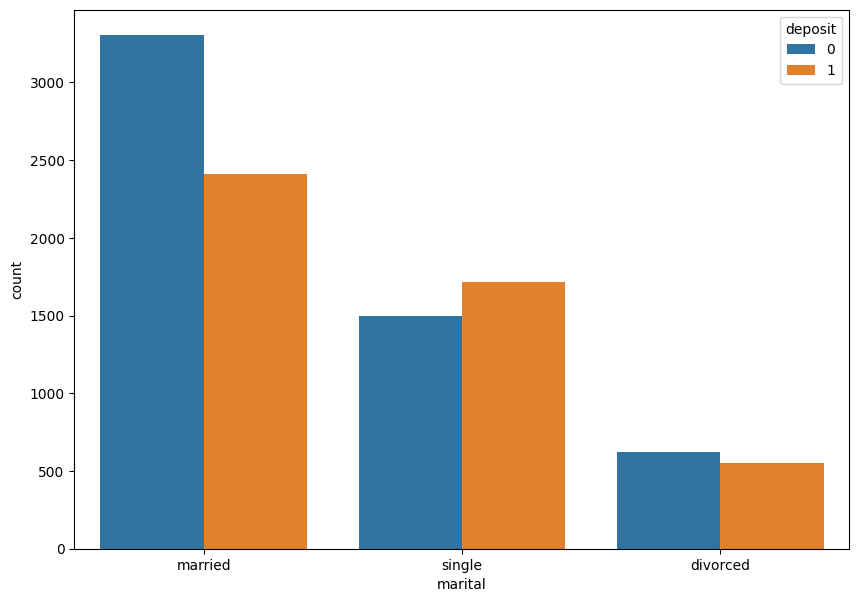

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='marital', hue='deposit', order=df['marital'].value_counts().index);

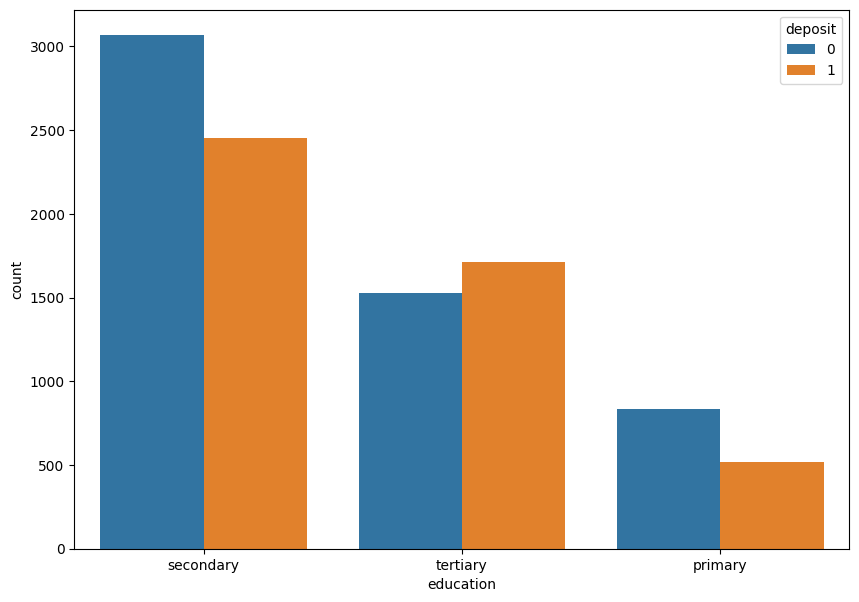

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='education', hue='deposit', order=df['education'].value_counts().index);

management       1135
technician        738
blue-collar       652
admin.            574
retired           432
services          345
student           245
unemployed        189
self-employed     161
entrepreneur      111
housemaid          99
Name: job, dtype: int64

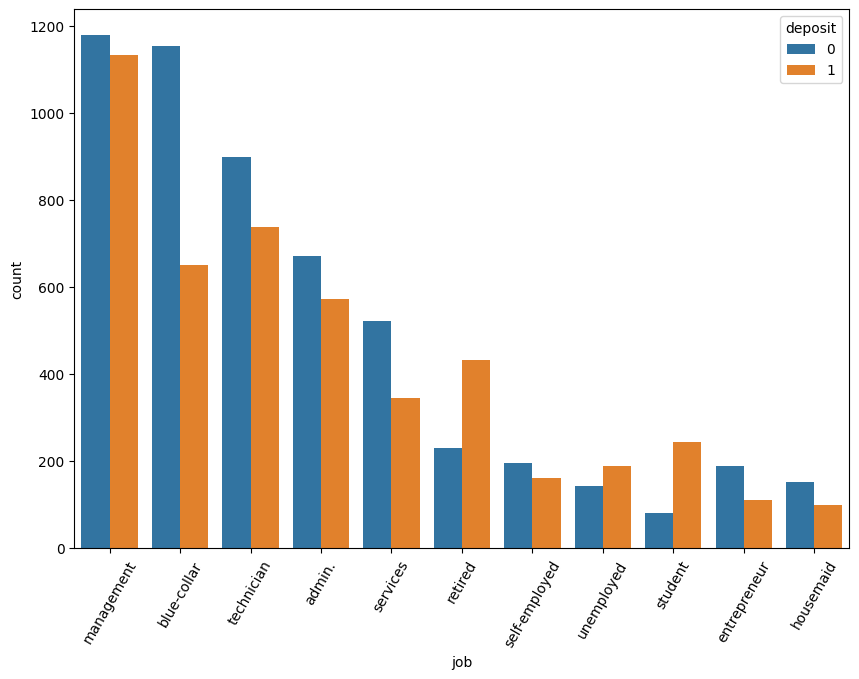

In [28]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='job', hue='deposit', order=df['job'].value_counts().index).xaxis.set_tick_params(rotation=60);
# В какой сфере занято наибольшее число клиентов банка?
df.job[df['deposit'] == 1].value_counts()

### Задание 11

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_pt_1 = df[df['deposit'] == 1].pivot_table(
    values='deposit',
    index=['education'],
    columns = 'marital',
    aggfunc='count',
    fill_value=0)
df_pt_1

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [30]:
# сводная таблица, для тех, кто не открыл депозит, в зависимости от семейного статуса и уровня образования
df_pt_0 = df[df['deposit'] == 0].pivot_table(
    values='deposit',
    index=['education'],
    columns = 'marital',
    aggfunc='count',
    fill_value=0)
df_pt_0

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


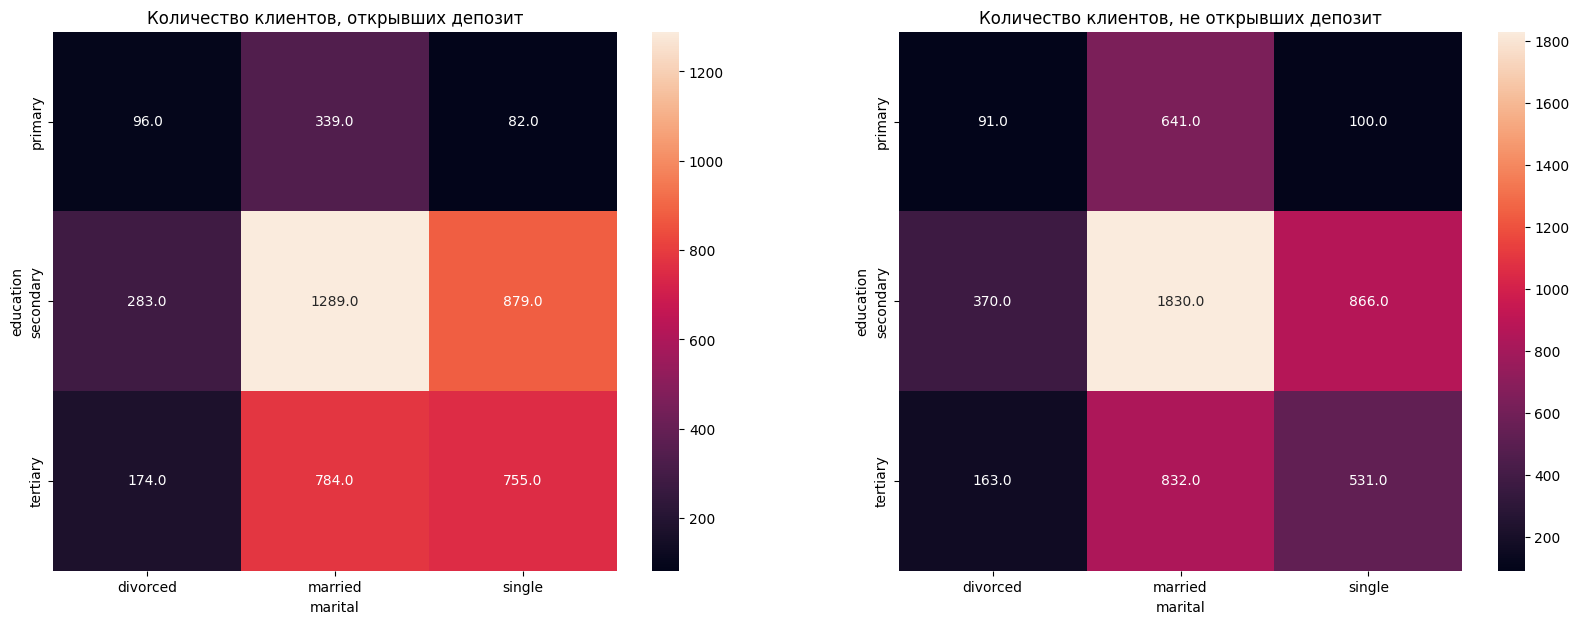

In [31]:
# Распределение клиентов в зависимости от образования(education) и семейного пложения(marital)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(df_pt_1, annot=True, fmt=".1f", ax=axes[0])
axes[0].set_title('Количество клиентов, открывших депозит')
sns.heatmap(df_pt_0, annot=True, fmt=".1f", ax=axes[1])
axes[1].set_title('Количество клиентов, не открывших депозит');

Cреди как открывших депозит, так и не открывших, больше всего людей c семейным статусом - married и уровнем образования - secondary.

## Часть 3: преобразование данных

### Задание 1

In [32]:
# преобразуйте уровни образования
le = LabelEncoder() # кодируем порядковым кодировщиком
df['education'] = le.fit_transform(df['education'])
print('Сумма получившихся значений для признака education:', df['education'].sum())

Сумма получившихся значений для признака education: 11995


In [33]:
# преобразуйте порядковую переменную для возраста
le = LabelEncoder() # кодируем порядковым кодировщиком
df['age_group'] = le.fit_transform(df['age_group'])

In [34]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.
round(df['deposit'].std(),3)

0.499

### Задания 2 и 3

In [35]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [36]:
round(df['default'].mean()+df['housing'].mean()+df['loan'].mean(), 3)

0.635

### Задание 4

In [37]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
#df = df.drop(['age'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

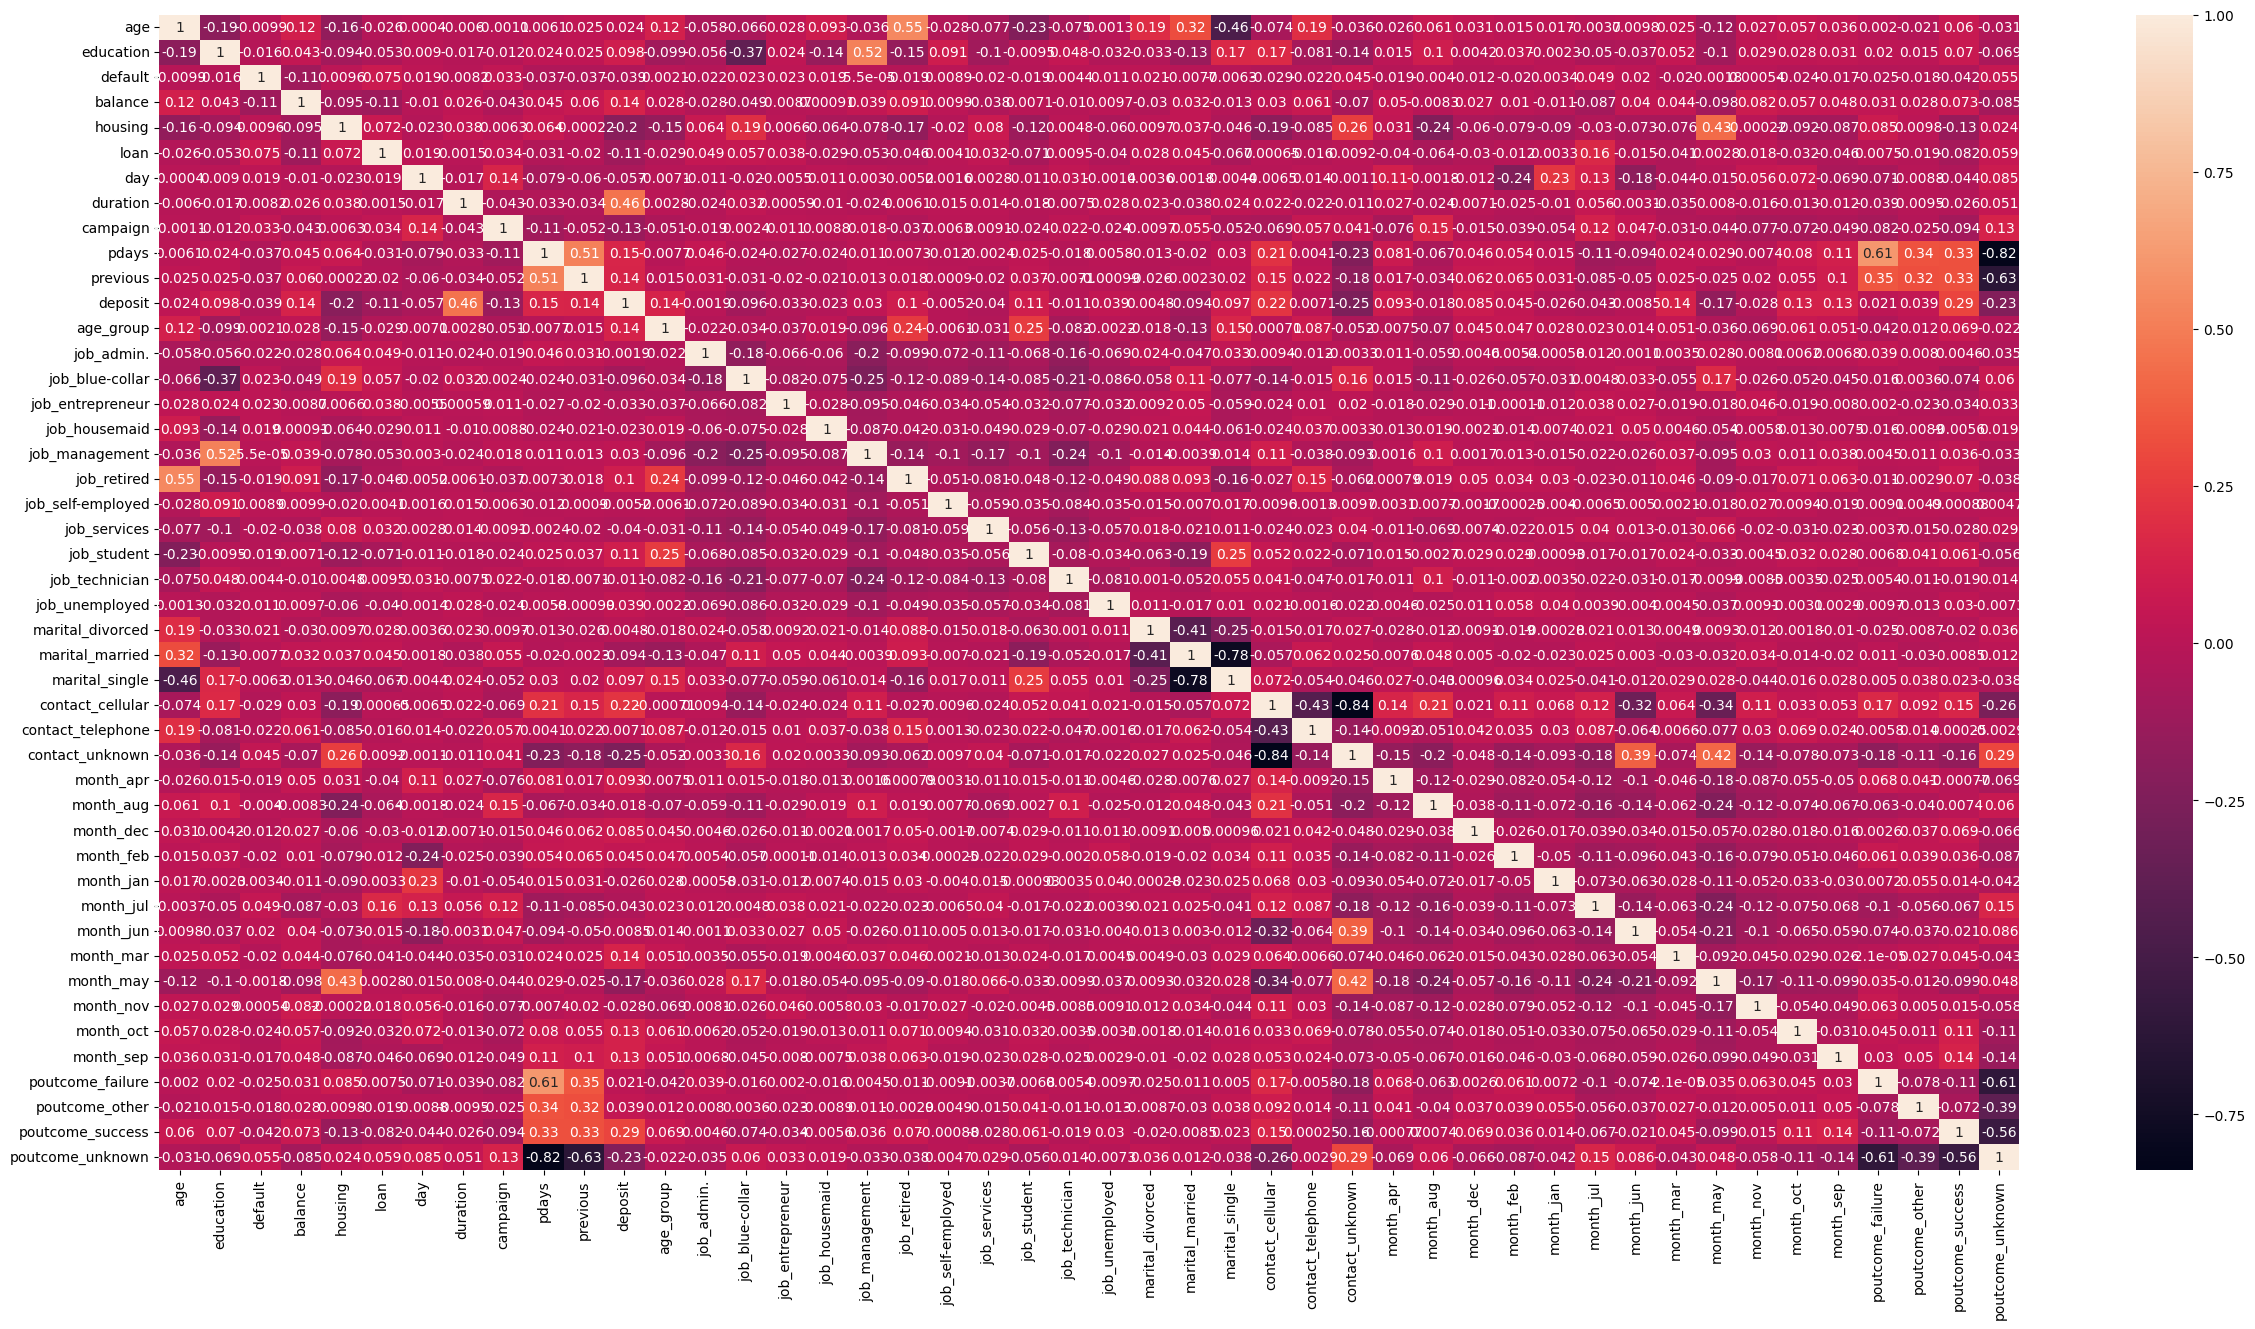

In [38]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot = True);

Существует сильная корреляция между признаками (больше 0,7):

pdays и poutcome_unknown,

marital_married и marital_single,

contact_cellular и contact_unknown.   

Мультиколлинеарность (больше 0,9) - отсутствует.


In [39]:
# В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.
corrs = round(df.corr(), 2).drop('deposit', axis=0)

fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Ранжирования коэффициентов корреляции'
             )

fig.show()

![](//plotly/newplot2)

С целевой переменной больше всего коррелирует признак duration.

### Задания 7 и 8

In [40]:
# разделим выборку на обучающую и тестовую
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [41]:
# рассчитайте необходимые показатели
print(f'Размер обучающей выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')
print('Cреднее значение целевой переменной на тестовой выборке:', round(y_test.mean(),2))
# проверим соотношения классов
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Test:\n', y_test.value_counts(normalize=True), sep='')

Размер обучающей выборки X_train=(6770, 45), y_train=6770
Размер тестовой выборки X_test=(3335, 45), y_test=3335
Cреднее значение целевой переменной на тестовой выборке: 0.46
Train:
0    0.53678
1    0.46322
Name: deposit, dtype: float64
Test:
0    0.536732
1    0.463268
Name: deposit, dtype: float64


### Задание 9

In [42]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [43]:
# создадим новый датафрейм на основе 15 наиболее подходящих признаков
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [44]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки.
print(round(X_test_scaled[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [45]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Делаем предсказание
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
#Выводим метрику
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

Test F1: 0.777
Test precision: 0.825
Test recall: 0.734
Test accuracy: 0.805


### Задания 2,3,4

In [46]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)
#Обучаем модель по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Делаем предсказание
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
#Выводим метрику
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Test F1: 0.803
Test precision: 0.768
Test recall: 0.841
Test accuracy: 0.809


Модель решающих деревьев показала лучшие метрики качества по сравнению с логистической регрессией.

### Задание 5

In [47]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search_forest = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=3,
    n_jobs = -1,
    scoring='f1',
    return_train_score=True
)
grid_search_forest.fit(X_train_scaled, y_train)

y_test_pred = grid_search_forest.predict(X_test_scaled)

print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
Test F1: 0.804
Test precision: 0.794
Test recall: 0.813
Test accuracy: 0.816


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [48]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)

#Выводим значения метрики
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test F1: 0.819
Test precision: 0.803
Test recall: 0.835
Test accuracy: 0.828


### Задания 2 и 3

In [49]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

#Выводим значения метрики
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test F1: 0.817
Test precision: 0.802
Test recall: 0.832
Test accuracy: 0.827


Модель случайного леса показала лучшие метрики качества по сравнению с градиентным бустингом.

### Задание 4

In [50]:
# объедините уже известные вам алгоритмы с помощью стекинга
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', dt),
    ('log_reg', log_reg),
    ('gb', gb)
]
#Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

#Выводим значения метрики
y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)

print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Test F1: 0.807
Test precision: 0.804
Test recall: 0.809
Test accuracy: 0.820


### Задание 5

In [51]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importance = pd.DataFrame([gb.feature_importances_], columns=X_train.columns.values)
fig = px.bar(x = list(importance.loc[0].sort_values(ascending=False).index),
    y=round(importance.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='Распределение признаков по важности в модели градиентного бустинга'
)
fig.show()

![](//plotly/newplot1)

Наибольшую важность имеют три признака:

1. duration (продолжительность контакта в секундах)

2. poutcome_success (успешный результат прошлой маркетинговой кампании)

3. contact_unknown (неизвестный тип контакта с клиентом)

### Задания 6,7,8

In [52]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)

  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'Наилучшие значения гиперпараметров {study.best_params}')
print('Test accuracy: {:.3f}'.format(model.score(X_test_scaled, y_test)))

#Выводим значения метрики
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

print('Test F1: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Test precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Test recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2023-09-15 22:16:18,822] A new study created in memory with name: RandomForestClassifier
[I 2023-09-15 22:16:19,572] Trial 0 finished with value: 0.8454901960784313 and parameters: {'n_estimators': 191, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8454901960784313.
[I 2023-09-15 22:16:20,216] Trial 1 finished with value: 0.8583059339282919 and parameters: {'n_estimators': 155, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8583059339282919.
[I 2023-09-15 22:16:20,870] Trial 2 finished with value: 0.8766567908934976 and parameters: {'n_estimators': 144, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8766567908934976.
[I 2023-09-15 22:16:21,427] Trial 3 finished with value: 0.8414096916299559 and parameters: {'n_estimators': 149, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8766567908934976.
[I 2023-09-15 22:16:21,941] Trial 4 finished with value: 0.8492163009404389 and parameters: {'

Наилучшие значения гиперпараметров {'n_estimators': 116, 'max_depth': 25, 'min_samples_leaf': 2}
Test accuracy: 0.827
Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3634
           1       0.91      0.94      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test F1: 0.819
Test precision: 0.794
Test recall: 0.845
Test accuracy: 0.827


**Выводы:**
В результате построения нескольких моделей машинного обучения получились следующие результаты метрик:

|   Модель                      |  F1   | accuracy |
|-------------------------------|-------|----------|
| LogisticRegression            | 0.777 |  0.805   |
| DecisionTreeClassifier        | 0.803 |  0.809   | 
| GridSearchCV                  | 0.804 |  0.816   |
| RandomForestClassifier        | 0.819 |  0.828   |
| GradientBoostingClassifier    | 0.817 |  0.827   |
| StackingClassifier            | 0.807 |  0.820   |
| Optuna                        | 0.819 |  0.827   |

Таким образом, для решения задачи классификации в данном кейсе хорошо себя показала модель случайного леса, а также модели градиентного бустинга и Optuna.